In [127]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from scipy.stats import truncnorm
import arviz as az
import matplotlib as mpl
sns.set_style('white')

<h2>Theory</h2>

In [128]:
#Theoretical model
def replicate_f(rho,tc):
    temp= lambda x : stats.norm.pdf(x)*stats.norm.cdf((rho*x-tc)/np.sqrt(1-rho**2))
    return sp.integrate.quad(temp, a=tc, b=np.inf)
 
def replicate(tau=.1, sigma=0, epsilon=1, n=30, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc/np.sqrt((epsilon**2)/n + tau**2 + sigma**2)
    rho = tau**2/(epsilon**2/n + tau**2 + sigma**2)
    return(replicate_f(rho,tc)/stats.norm.cdf(-tc))[0]
                                                
def publish(tau=.1, sigma=0, epsilon=1, n=30, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc/np.sqrt((epsilon**2)/n + tau**2 + sigma**2)
    return(2*sp.stats.norm.cdf(-tc))

def type_s(tau=.4, sigma=.2, epsilon=1, n=100, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc
    
    temp= lambda x : stats.truncnorm(0,np.inf,scale=tau).pdf(x) * \
                     stats.norm(loc=x,scale=np.sqrt((epsilon**2)/n + sigma**2)).cdf(-tc) 
    return(sp.integrate.quad(temp, a=0, b=np.inf))[0] 

def type_m(tau=.4, sigma=.2, epsilon=1, n=100, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc
    
    
    #lower bound adjusted as per 
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
    above_func = lambda x: (truncnorm((tc-x)/np.sqrt((epsilon**2)/n + sigma**2),
                                      np.inf, 
                                      x, 
                                      scale=np.sqrt((epsilon**2)/n + sigma**2)).stats()[0]) * \
                                     truncnorm(0, np.inf,scale=tau).pdf(x) 
    above = sp.integrate.quad(above_func, a=0, b=np.inf)[0]/(tau * np.sqrt(2/np.pi))


    return above 

type_m_vec = np.vectorize(type_m)
type_s_vec = np.vectorize(type_s)
replicate_vec = np.vectorize(replicate)
publish_vec = np.vectorize(publish)

In [174]:
def type_s_alternate(tau=.4, sigma=.2, epsilon=1, n=100, alpha=0.05):
    tc = sp.stats.norm.ppf(1-alpha/2)
    tc = (epsilon/np.sqrt(n))*tc
    
    func = lambda x :  stats.norm(loc=x, 
                                  scale=np.sqrt((epsilon**2)/n + sigma**2)).cdf(-tc) * \
                                  stats.norm(0, scale=tau).pdf(x) 

    t_lessthan_tc = stats.norm(0, scale=np.sqrt((epsilon**2)/n + sigma**2 + tau**2)).cdf(-tc)
    d_greater_0 = stats.norm(0, scale=np.sqrt((epsilon**2)/n + sigma**2 + tau**2)).cdf(0)
    integ = 2*(sp.integrate.quad(func, a=0, b=np.inf)[0] ) 
    return d_greater_0 * integ / t_lessthan_tc

type_s_alternate(tau=.001,sigma=100)

type_s_alternate_vec = np.vectorize(type_s_alternate)


In [175]:
type_s_alternate(tau=.001,sigma=100)


0.49999681192325557

In [176]:
type_s_alternate_vec(tau=0.1, sigma=1)

array(0.46338805)

In [181]:
N = 1000
res = 20
x= np.linspace(0.05, 1, res)
y = np.linspace(0.05,1, res)
X, Y =  np.meshgrid(x,y)
Z = type_s_alternate_vec(X, Y,1,N,.05) 


In [182]:
x2= np.linspace(0.05, 1, res)
y2 = np.linspace(0.05,1, res)
X2, Y2 =  np.meshgrid(x,y)
Z2 = type_s_vec(X, Y,1,N,.05) 


Text(0.5, 1.0, 'Pr(d’ > t_c | D<0) \n (Probability of achieving significance, \nfor an effect in the opposite direction)')

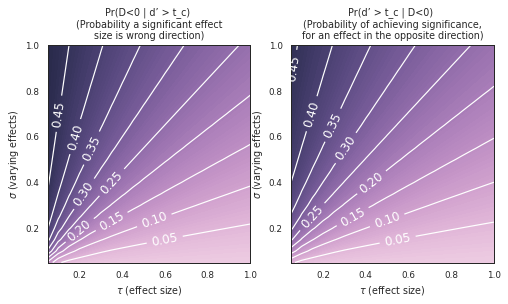

In [183]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
lls = np.linspace(0,.5,11)
CS= axs[0].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[0].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[0].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=.3",as_cmap=True))
axs[0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[0].set_xlabel(r'$\tau$' + ' (effect size)')
axs[0].set_title('Pr(D<0 | d’ > t_c) \n (Probability a significant effect \nsize is wrong direction)')# N=50, ' + r'$\epsilon=1$')   


CS= axs[1].contour(X2, Y2, Z2,zorder=2,levels=lls, colors='white')
axs[1].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[1].contourf(X2, Y2, Z2,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=.3",as_cmap=True))
axs[1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1].set_xlabel(r'$\tau$' + ' (effect size)')
axs[1].set_title('Pr(d’ > t_c | D<0) \n (Probability of achieving significance, \nfor an effect in the opposite direction)')# N=50, ' + r'$\epsilon=1$')  

In [180]:
type_m(tau=.001, sigma=.1)

326.6811254649601

<h3>Figure 1</h3>

In [41]:
pal = sns.color_palette("colorblind", n_colors=6)
def plot_figure_1(axs):
    
    #ax1.plot(np.linspace(0,2,100), stats.norm(0,.2).pdf(np.linspace(0,2,100)),color=pal[0])
    
    #Plot Distribution of tau
    ax1.fill_between(np.linspace(0,2,100), 
                     np.zeros(100),
                     stats.norm(0,.2).pdf(np.linspace(0,2,100)),
                     color=pal[0],alpha=.5)
    ax1.plot([0, .2], [1.2, 1.2],color='k')
    ax1.text(x=.1,y=1.25, s=r'$\tau$',fontsize='x-large',color='k')

    #Add true effect size text
    ax1.text(x=.2,y=2.1, s=r'$d_{true}$',fontsize='x-large')

    #Set Labels
    ax1.set_xlabel('Effect size')
    ax1.set_ylabel('Density')



    ax1.text(x=.1,y=1.25, s=r'$\tau$',fontsize='x-large')
    ax1.plot([0.2, .31], [1.1, 1.1],color='k')


    ax1.plot([.2,.2], [0, 2],color='k',ls='--')
    ax1.text(x=.28,y=1.25, s=r'$\sigma$',fontsize='x-large',color='k')


    #ax1.plot(np.linspace(0,2,100), stats.norm(loc=0.25,scale=0.1).pdf(np.linspace(0,2,100))/2,color=pal[1])

    ax1.fill_between(np.linspace(0,2,100),
                     np.zeros(100),
                     stats.norm(loc=0.2,scale=0.1).pdf(np.linspace(0,2,100))/2,color=pal[1],alpha=.3)

    ax1.set_xlim(0,.8)
    ax1.set_ylim(0,2.3)

    ax1.plot([0.1,0.1],[0,stats.norm(loc=0.25,scale=0.1).pdf(0.1)/2],ls='--',color='k',zorder=3)
    ax1.text(x=.25,y=.73, s=r'$d_{original}$',fontsize='x-large')


    ax1.plot([0.3,0.3],[0,stats.norm(loc=0.25,scale=0.1).pdf(0.4)/2],ls='--',color='k')
    ax1.text(x=.05,y=.73, s=r'$d_{replication}$',fontsize='x-large')

    ax1.plot([.22,.22],[0,.4],color='k')
    ax1.text(x=.21,y=.43, s=r'$t_{crit.}$',fontsize='x-large')

    ax1.fill_between(np.linspace(0,2,100),
                     np.zeros(100),
                     stats.norm(loc=0.3,scale=0.03).pdf(np.linspace(0,2,100))/20,color=pal[2],alpha=.3)

    ax1.text(x=.31,y=.1, s=r'$\frac{\epsilon}{\sqrt{n}}$',fontsize='x-large')
    ax1.plot([0.3, .34], [0.27, 0.27],color='k')
    
    ax1.set_xticks(np.linspace(0,1,11))

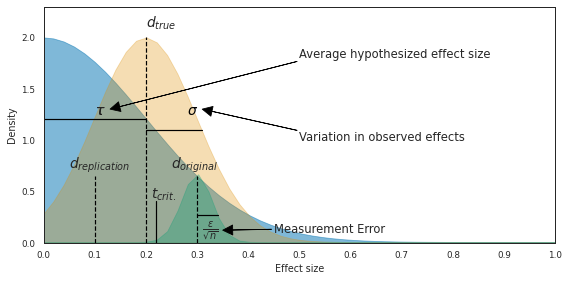

In [42]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, :])
sns.set_style('white')
#ax2 = fig.add_subplot(gs[1,0])
#ax3 = fig.add_subplot(gs[1,1])
plot_figure_1(ax1)

plt.annotate("Average hypothesized effect size", 
             xy=(0.13, 1.3), xytext=(.5, 1.8),
             arrowprops=dict(headwidth=10, headlength=10, width=0.1,color='k'),
             fontsize='large')

plt.annotate("Variation in observed effects", xy=(0.31, 1.30), xytext=(.5, 1.0),
             arrowprops=dict(headwidth=10, headlength=10, width=0.1,color='k'),
             fontsize='large')


plt.annotate("Measurement Error", xy=(0.35, .12), xytext=(.45, 0.1),
             arrowprops=dict(headwidth=10, headlength=10, width=0.1,color='k'),
             fontsize='large')

plt.savefig('talkfig7.png',dpi=400, transparent=True)


plt.tight_layout()

#Move tau right (increase sigma, same for the green distribution)
plt.savefig('./output/figures/Figure1.png',dpi=300, transparent=False)

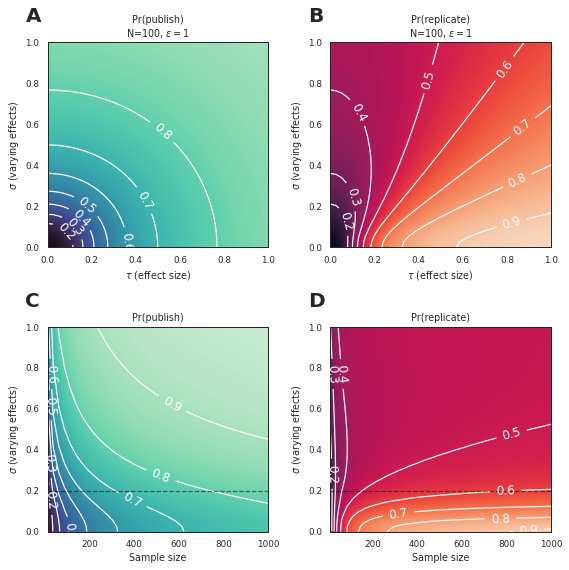

In [50]:
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("mako"))

fig, axs = plt.subplots(2,2,figsize=(8,8))

res = 40
N=100

axs0 = axs[0][0]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = publish_vec(tau=X, sigma=Y, epsilon=1, n=N)
lls = np.linspace(.2,1,9)
CS= axs0.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs0.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs0.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs0.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs0.set_xlabel(r'$\tau$' + ' (effect size)')
axs0.set_title('Pr(publish)\n' +'N='+str(N) + ', ' + r'$\epsilon=1$')


axs1 = axs[0][1]

x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = replicate_vec(X, Y,1,N,.05)

CS= axs1.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs1.clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(.0,1,100)
CSF= axs1.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs1.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs1.set_xlabel(r'$\tau$' + ' (effect size)')
axs1.set_title('Pr(replicate)\n' +'N='+str(N) + ', ' + r'$\epsilon=1$')




x= np.linspace(0, 1.0, res)
n = np.linspace(10,1000, res)
N,X =  np.meshgrid(n,x)
Z = publish_vec(tau=0.2, sigma=X, epsilon=1, n=N)

lls = np.linspace(.2,1,9)
CS= axs[1][0].contour(N,X, Z,levels=lls,zorder=2,colors='white')
axs[1][0].clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
axs[1][0].plot([10,1000],[.2,.2],color='k',ls='--',alpha=.5)
CSF= axs[1][0].contourf(N,X, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs[1][0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1][0].set_title('Pr(publish)')# N=50, ' + r'$\epsilon=1$')   
axs[1][0].set_xlabel('Sample size')

x= np.linspace(0, 1.0, res)
n = np.linspace(10,1000, res)
N,X =  np.meshgrid(n,x)
Z = replicate_vec(tau=0.2, sigma=X, epsilon=1, n=N)
lls = np.linspace(.2,1,9)
CS= axs[1][1].contour(N,X, Z,levels=lls,zorder=2,colors='white')
axs[1][1].clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs[1][1].contourf(N,X, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs[1][1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1][1].set_xlabel('Sample size')
axs[1][1].set_title('Pr(replicate)')# N=50, ' + r'$\epsilon=1$')   
axs[1][1].plot([10,1000],[.2,.2],color='k',ls='--',alpha=.5)


axs = axs.flat
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
plt.tight_layout()

plt.savefig('./output/figures/figure2.png',dpi=300)

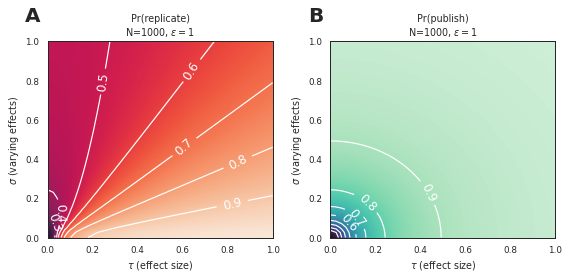

In [51]:
N=1000
fig, axs = plt.subplots(1,2,figsize=(8,4))

x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = replicate_vec(X, Y,1,N,.05)

axs2 = axs[0]
lls = np.linspace(.3,1,8)
CS= axs2.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs2.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,500)
CSF= axs2.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs2.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs2.set_xlabel(r'$\tau$' + ' (effect size)')
axs2.set_title('Pr(replicate)\n' +'N='+str(N) + ', ' + r'$\epsilon=1$')



axs3 = axs[1]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z = publish_vec(tau=X, sigma=Y, epsilon=1, n=N)
ax = plt.gca()
lls = np.linspace(.2,1,9)
CS= axs3.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
ax.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,500)
CSF= axs3.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs3.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs3.set_xlabel( r'$\tau$' + ' (effect size)')
axs3.set_title('Pr(publish)\n' +'N='+str(N) + ', ' + r'$\epsilon=1$')


axs = axs.flat
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
plt.tight_layout()

plt.savefig('./output/figures/SI1000.png',dpi=300)

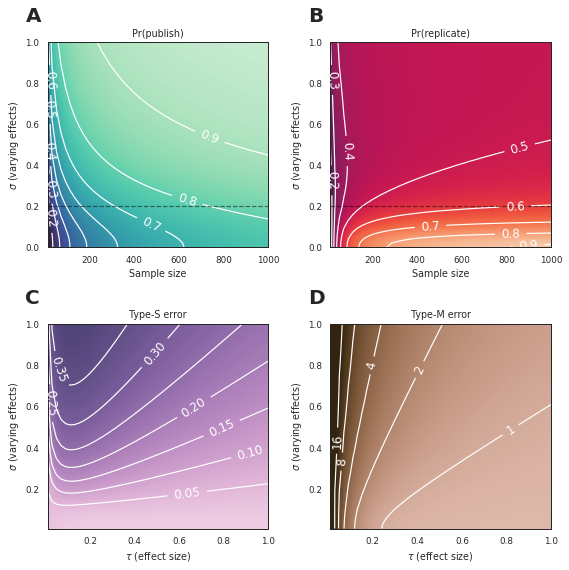

In [33]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
res = 50
N=50

x= np.linspace(0, 1.0, res)
n = np.linspace(10,1000, res)
N,X =  np.meshgrid(n,x)
Z = publish_vec(tau=0.2, sigma=X, epsilon=1, n=N)

lls = np.linspace(.2,1,9)
CS= axs[0][0].contour(N,X, Z,levels=lls,zorder=2,colors='white')
axs[0][0].clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
axs[0][0].plot([10,1000],[.2,.2],color='k',ls='--',alpha=.5)
CSF= axs[0][0].contourf(N,X, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs[0][0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[0][0].set_title('Pr(publish)')# N=50, ' + r'$\epsilon=1$')   

axs[0][0].set_xlabel('Sample size')

x= np.linspace(0, 1.0, res)
n = np.linspace(10,1000, res)
N,X =  np.meshgrid(n,x)
Z = replicate_vec(tau=0.2, sigma=X, epsilon=1, n=N)
lls = np.linspace(.2,1,9)
CS= axs[0][1].contour(N,X, Z,levels=lls,zorder=2,colors='white')
axs[0][1].clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs[0][1].contourf(N,X, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs[0][1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[0][1].set_xlabel('Sample size')
axs[0][1].set_title('Pr(replicate)')# N=50, ' + r'$\epsilon=1$')   
axs[0][1].plot([10,1000],[.2,.2],color='k',ls='--',alpha=.5)


x= np.linspace(0.01, 1, res)
y = np.linspace(0.01,1, res)
X, Y =  np.meshgrid(x,y)
Z = type_s_vec(X, Y,1,N,.05) 


lls = np.linspace(0,.5,11)
CS= axs[1][0].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[1][0].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[1][0].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=.3",as_cmap=True))
axs[1][0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1][0].set_xlabel(r'$\tau$' + ' (effect size)')
axs[1][0].set_title('Type-S error')# N=50, ' + r'$\epsilon=1$')   


x= np.linspace(0.01, 1, res)
y = np.linspace(0.01,1, res)
X, Y =  np.meshgrid(x,y)

Z = type_m_vec(X, Y,1,N,.05) 

lls = np.logspace(0,4,5,base=2)
CS= axs[1][1].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[1][1].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.logspace(0,8,1000,base=2)-1
CSF= axs[1][1].contourf(X, Y, Z,zorder=1,levels=levels, 
                        norm=mpl.colors.LogNorm(vmin=.5, vmax=16),
                        cmap=sns.color_palette("ch:start=1.3,rot=-.1",as_cmap=True))

axs[1][1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1][1].set_xlabel(r'$\tau$' + ' (effect size)')
axs[1][1].set_title('Type-M error')# N=50, ' + r'$\epsilon=1$')   
axs[1][1].fill_between([0,1],[1,1],color='k',zorder=-1)
axs[1][1].set_ylim(0.01,1)
axs[1][1].set_xlim(0.01,1)
import string
axs = axs.flat
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('./output/figures/figure3.png',dpi=300)

Text(0.5, 1.0, 'Type-S:\n N=500, $\\epsilon=1$')

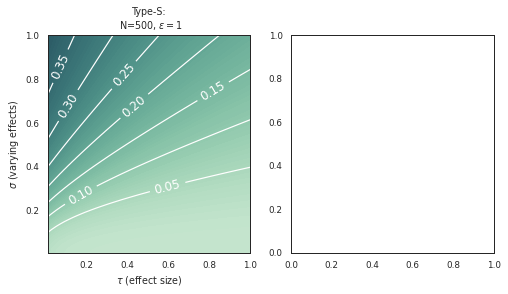

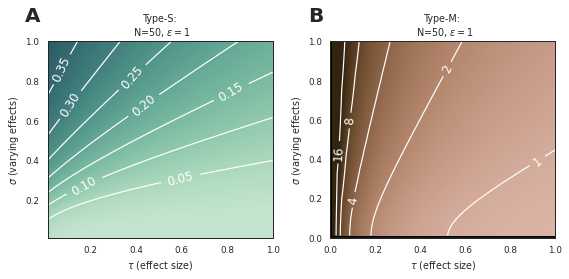

In [34]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
res = 50
N=50


x= np.linspace(0.01, 1, res)
y = np.linspace(0.01,1, res)
X, Y =  np.meshgrid(x,y)
Z = type_s_vec(X, Y,1,N,.05) 


lls = np.linspace(0,.5,11)
CS= axs[0].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[0].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[0].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=-.3",as_cmap=True))
axs[0].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[0].set_xlabel(r'$\tau$' + ' (effect size)')
axs[0].set_title('Type-S:\n N=' + str(N) + ', ' + r'$\epsilon=1$')   



x= np.linspace(0.01, 1, res)
y = np.linspace(0.01,1, res)
X, Y =  np.meshgrid(x,y)

Z = type_m_vec(X, Y,1,N,.05) 

lls = np.logspace(0,4,5,base=2)
CS= axs[1].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[1].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.logspace(0,8,1000,base=2)-1
CSF= axs[1].contourf(X, Y, Z,zorder=1,levels=levels, 
                        norm=mpl.colors.LogNorm(vmin=.5, vmax=16),
                        cmap=sns.color_palette("ch:start=1.3,rot=-.1",as_cmap=True))

axs[1].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[1].set_xlabel(r'$\tau$' + ' (effect size)')
axs[1].set_title('Type-M:\n N=' + str(N)+', ' + r'$\epsilon=1$')   
axs[1].fill_between([0,1],[1,1],color='k',zorder=-1)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1) 

import string
axs = axs.flat
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('./output/figures/SIFigureTypeSM.png',dpi=300)

In [ ]:
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("mako"))

fig, axs = plt.subplots(1,3,figsize=(12,4))

p_true = .1
res = 10
N=50

axs0 = axs[0]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0.01,1.0, res)
X, Y =  np.meshgrid(x,y)
Z1 = publish_vec(tau=0, sigma=Y, epsilon=1, n=N)
Z2 = publish_vec(tau=X, sigma=Y, epsilon=1, n=N)
Z = p_true* Z1 + (1-p_true) * Z2

lls = np.linspace(.2,1,9)
CS= axs0.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs0.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs0.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs0.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs0.set_xlabel(r'$\tau$' + ' (effect size)')
axs0.set_title('Pr(publish)\n' +'N=50, ' + r'$\epsilon=1$')


axs1 = axs[1]
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z1 = replicate_vec(X, Y, 1, N, .05)
Z2 = replicate_vec(0.01, Y,1,N,.05)
Z = p_true * Z1 + (1-p_true) * Z2

CS= axs1.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs1.clabel(CS, colors = 'w', fontsize=12) 

levels = np.linspace(.0,1,100)
CSF= axs1.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs1.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs1.set_xlabel(r'$\tau$' + ' (effect size)')
axs1.set_title('Pr(replicate)\n' +'N=50, ' + r'$\epsilon=1$')



x= np.linspace(0.001, 1, res)
y = np.linspace(0.001,1, res)
X, Y =  np.meshgrid(x,y)
Z1 = type_s_vec(X, Y,1,N,.05) 
Z2 = type_s_vec(0.01, Y,1,N,.05) 
Z = p_true * Z1 + (1-p_true) * Z2

lls = np.linspace(0,.5,11)
CS= axs[2].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[2].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[2].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=.3",as_cmap=True))
axs[2].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[2].set_xlabel(r'$\tau$' + ' (effect size)')
axs[2].set_title('Type-S error') 

import string
axs = axs.flat
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('./output/figures/SIFigurePTrue10percentN50.png',dpi=300)

In [ ]:
sns.set_context('paper',font_scale=1)
sns.set_palette(sns.color_palette("mako"))

fig, axs = plt.subplots(1,3,figsize=(12,4))

p_true = .1
res = 10
N=500

axs0 = axs[0]
sns.set_context('paper')
x= np.linspace(0, 1.0, res)
y = np.linspace(0.01,1.0, res)
X, Y =  np.meshgrid(x,y)
Z1 = publish_vec(tau=0, sigma=Y, epsilon=1, n=N)
Z2 = publish_vec(tau=X, sigma=Y, epsilon=1, n=N)
Z = p_true* Z1 + (1-p_true) * Z2

lls = np.linspace(.2,1,9)
CS= axs0.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs0.clabel(CS, colors = 'w', fontsize=12) #contour line labels
levels = np.linspace(.0,1,1000)
CSF= axs0.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("mako",as_cmap=True))
axs0.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs0.set_xlabel(r'$\tau$' + ' (effect size)')
axs0.set_title('Pr(publish)\n' +'N=50, ' + r'$\epsilon=1$')


axs1 = axs[1]
x= np.linspace(0, 1.0, res)
y = np.linspace(0,1.0, res)
X, Y =  np.meshgrid(x,y)
Z1 = replicate_vec(X, Y, 1, N, .05)
Z2 = replicate_vec(0.01, Y,1,N,.05)
Z = p_true * Z1 + (1-p_true) * Z2

CS= axs1.contour(X, Y, Z,levels=lls,zorder=2,colors='white')
axs1.clabel(CS, colors = 'w', fontsize=12) 

levels = np.linspace(.0,1,100)
CSF= axs1.contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("rocket",as_cmap=True))
axs1.set_ylabel(r'$\sigma$' + ' (varying effects)')
axs1.set_xlabel(r'$\tau$' + ' (effect size)')
axs1.set_title('Pr(replicate)\n' +'N=50, ' + r'$\epsilon=1$')



x= np.linspace(0.001, 1, res)
y = np.linspace(0.001,1, res)
X, Y =  np.meshgrid(x,y)
Z1 = type_s_vec(X, Y,1,N,.05) 
Z2 = type_s_vec(0.01, Y,1,N,.05) 
Z = p_true * Z1 + (1-p_true) * Z2

lls = np.linspace(0,.5,11)
CS= axs[2].contour(X, Y, Z,zorder=2,levels=lls, colors='white')
axs[2].clabel(CS, colors = 'w', fontsize=12) #contour line labels

levels = np.linspace(0,.5,100)
CSF= axs[2].contourf(X, Y, Z,zorder=1,levels=levels,cmap=sns.color_palette("ch:start=2.8,rot=.3",as_cmap=True))
axs[2].set_ylabel(r'$\sigma$' + ' (varying effects)')
axs[2].set_xlabel(r'$\tau$' + ' (effect size)')
axs[2].set_title('Type-S error') 

import string
axs = axs.flat
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.tight_layout()
plt.savefig('./output/figures/SIFigurePTrue10percentN500.png',dpi=300)